Nonlinear **Shrodinger equation** looks like

$$
iw_t + \alpha w_{xx} + \beta w|w|^2 = 0
$$

Here $w = w(x, t)$ is a complex function of two real arguments, $\alpha$.
and $\beta$ are permanent physical parameters. In mathematical physics, the equation has become widely known in the last half-century. It is a model equation for nonlinear processes and is used in various fields of physics, for example in nonlinear optics and plasma physics.

We need to consider Cauchy's problem for the *Shrodinger Eq*. First of all, let's write the equation for real and imaginary parts of an unknown function by writing $w = u + iv$.
Then we will write down all the intermediate calculations for the convenience of their verification. Let's put $w$ into the equation.

$$
i(u_t + iv_t) + \alpha(u_{xx} + iv_{xx}) + \beta(u + iv)(u^2 + v^2) = 0
$$

$$
u_t + \alpha v_{xx} + \beta v(u^2 + v^2) = 0 \\
v_t - \alpha u_{xx} - \beta u(u^2 + v^2) = 0
$$

This system allows you to solve *Eq System* without using complex calculations. 

$$
\left\{\begin{matrix}
i\partial_tu + \alpha\partial_x^2u = \beta|u|^2u \\ 
u(x,t_0) = f(x)
\end{matrix}\right.
$$



## Different patterns

For example, by means of differential equations with partial derivatives it is possible to solve problems of heat conductivity, diffusion, many physical and chemical processes.

As a rule, it is not possible to find an exact solution of these equations, so the widest application has received approximate methods of their solution. In the given work we limit ourselves to consideration of differential equations with partial derivatives of the second order (2eme ordre O(3)), and more precisely differential equations with partial derivatives of the second order of parabolic type, when these equations are linear, and the desired function depends on two variables.

For solving differential equations of parabolic type there are several methods of their numerical solution on the computer, but the grid method occupies a special position as it provides the best ratios of speed, accuracy of the obtained solution and simplicity of computational algorithm realization. The mesh method is also called the finite difference method.
Crank-Nicholson Algorithm (https://www.math.ntnu.no/emner/TMA4135/2015h/notater/crank-nicolson/cn.pdf)



In [1]:
using Plots 


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [2]:
function soliton( x; β = 2, x0=3., AA=2.0, BB=1.0, C1=0.0, C2=0.0 )
	AA*sqrt(2.0/β)*exp(im*(BB*(x-x0)+C1)) /
        	cosh(AA*(x-x0)+C2)
end

bisoliton(x) = ( cosh(x)-x*sinh(x) ) / ( 1 + 2x^2 + cosh(2x) )

bisoliton (generic function with 1 method)

In [3]:
function schredinger(startcond;
	num = 1, # 1 - KN, 2 - DF, 3 - RB
    L = 10.0, # thread length
    Lt = 5.0, # upper threshold in time
    N::Int64 = 5000, # coordinate steps
    M::Int64 = 20000, # by time
    β = 2. , # the coefficient for a nonlinear summand
    α = 1. , # the coefficient at the 2nd core
    σ = 1., # control the non-linearity
    δ = 0.5 ,# 
    λ = 0.1 , 
    x0 = 0.0)
    cutn::Int64 = N÷100 # integer division
    cutm::Int64 = M÷100 # for charts only every 100th step

    ξ = zeros(Complex, N)
    η = zeros(Complex, N)
    V = zeros(Complex, N)
    U = zeros(Complex, N÷cutn, M÷cutm)

    dx = L/(N-1)
    dt = Lt/(M-1)
    #dt = λ*dx

    X = [0:N-1;]*dx .+ x0 # coords
	coordgrid = X[cutn:cutn:N] # Graph layout
	timesgrid = [cutm*dt:cutm*dt:M*dt;]

    println("dt = ", dt, " dx = ", dx, " dt/dx = ", dt/dx)

    V .= startcond.(X)

	function compression(v::Array{Complex,1}, k)
		if mod(k, cutm) == 0
            for i = 1:N  
                if mod(i, cutn) == 0
                    U[i÷cutn,k÷cutm] = v[i]
                end
            end
            print("$(k÷cutm) ") 
        end
	end

    function progonka!(v::Array{Complex,1})

        b = 2.0 - im*dx^2/(dt*α*σ) - (1.0-δ)*dx^2*β*abs2(v[2])/(α*σ)
        d = (σ-1.0)/σ*(v[1]+v[3]) + v[2]*( im*dx^2/(dt*σ*α) +  
                2.0*(1.0-σ)/σ - δ*dx^2/(α*σ)*β*abs2(v[2]) )

        ξ[3] = 1.0/b
        η[3] = -d/b

        @inbounds for i = 3:N-2
            b = 2.0 - im*dx^2/(dt*α*σ) - (1.0-δ)*dx^2*β*abs2(v[i])/(α*σ)
            d = (σ-1.0)/σ*(v[i-1] + v[i+1])+v[i]*( im*dx^2/(dt*σ*α) + 
                2.0*(1.0-σ)/σ - δ*dx^2/(α*σ)*β*abs2(v[i]) )

            ξ[i+1] = 1.0 / (b-ξ[i])
            η[i+1] = (η[i]-d) / (b-ξ[i])
        end

        b = 2.0 - im*dx^2/(dt*α*σ) - (1.0-δ)*dx^2*β*abs2(v[N-1])/(α*σ)
        d = (σ-1)/σ*(v[N-2]+v[N]) + v[N-1]*( im*dx^2/(dt*σ*α) + 
            2*(1-σ)/σ - δ*dx^2/(α*σ)*β*abs2(v[N-1]) )

        η[N] = (η[N-1]-d)/(b-ξ[N-1])
        v[N-1] = η[N]

        @inbounds for i = 2:N-2
            v[N-i] = ξ[N-i+1]*v[N-i+1] + η[N-i+1]
        end
    end
    
    function kranknickolson!(v::Array{Complex,1})
    	for k = 1:M
	        progonka!(v)
            #v[1] = 0.0 #!boundary condition on the left boundary     
	        #v[N] = 0.0 #!boundary condition at the right boundary 
	# we send every hundredth step out
	        
	        compression(v, k) 
	    end
    end

    function dufortfrankel!( v::Array{Complex,1} )

    	v0 = zeros(Complex, N)
    	v1 = copy(v) 

		function caterpillar()
			v0 .= v1 # layer transfer
			v1 .= v
		end
# second run (Crank-Nicholson)
		progonka!(v)
		caterpillar()

	    for k = 2:M
            
		    @inbounds for i = 2:N-1
		        v[i] = ( v0[i]*(1. - im*( 2*dt/dx^2 - dt*β*abs2(v1[i])) ) + im*2*dt/dx^2 * 
		        (v1[i+1]+v1[i-1]) ) / ( 1. + im*(2dt/dx^2 - dt*β*abs2(v1[i]) ) )
		    end

			caterpillar()
	        #v[1] = 0.0 # graph  
	        #v[N] = 0.0  
	        compression(v, k) 
	    end
	end
    
	function besserelaxation!( v::Array{Complex,1} )

		vv = zeros(Complex, N)

        function Besse!( v::Array{Complex,1} )

            @inbounds for i = 2:N-1
                vv[i] = -vv[i] + 2*abs2(v[i])
            end

            b = -2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[2]
            d = - v[1] + (2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[2] )*v[2] - v[3]

            ξ[3] = 1.0/b
            η[3] = -d/b

            @inbounds for i=3:N-2
                b = -2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[i]
                d = -v[i-1] + (2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[i] )*v[i] - v[i+1]

                ξ[i+1] = 1.0 / ( b-ξ[i] )
                η[i+1] = ( η[i] - d ) / ( b - ξ[i] )
            end

            if(abs(b) < 2.)
               println("b = ", b)
            end

            b = -2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[N-1]
            d = - v[N-2] + (2.0*im*dx^2/(dt*α*σ) + 2.0 - β*dx^2*vv[N-1] )*v[N-1] - v[N]

            η[N] = ( η[N-1] - d ) / ( b - ξ[N-1] )
            v[N-1] = η[N]

            @inbounds for i=2:N-2
                v[N-i] = ξ[N-i+1]*v[N-i+1] + η[N-i+1]
            end
        end
        
		for k = 1:M

	        Besse!(v) 
             #v[1] = 0.0 # Granule    
             #v[N] = 0.0    
            #vv[1] = 0.0        
            #vv[N] = 0.0 
	        compression(v, k)
	    end
	end

	method_of = [ kranknickolson!, dufortfrankel!, besserelaxation! ]
    
    method_of[num](V)

    real(U), coordgrid, timesgrid
end

schredinger (generic function with 1 method)

In [4]:
#@time S, R, T = schredinger(sin, num = 2, N = 5000, M = 20000, L = 2π );
#@time S, R, T = schredinger(bisoliton, num = 2, N = 5000, M = 20000, L = 8π, x0 = -4π );
@time S, R, T = schredinger(soliton, num = 3, N = 5000, M = 20000, L = 10, Lt =10, x0 = 0.0 );

dt = 0.0005000250012500625 dx = 0.002000400080016003 dt/dx = 0.24996249812490626
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 226.342906 seconds (2.87 G allocations: 75.545 GiB, 18.44% gc time)


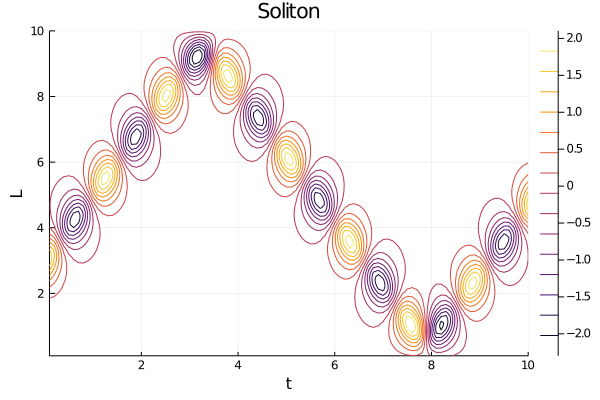

In [5]:
contour(T, R, S, xaxis = "t", yaxis = "L", title = "Soliton")

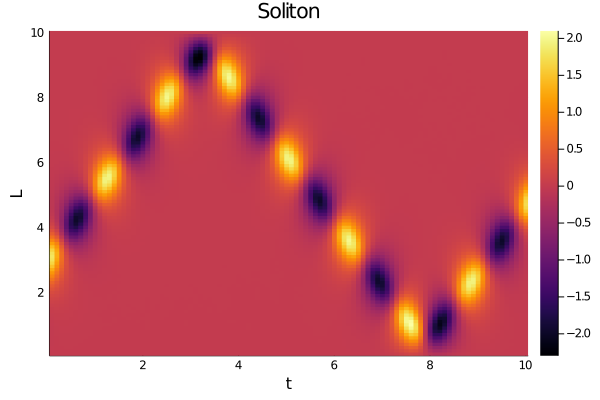

In [6]:
heatmap(T, R, S, xaxis = "t", yaxis = "L", title = "Soliton")

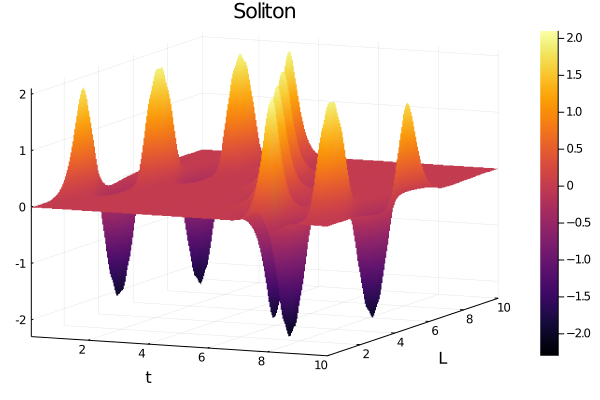

In [7]:
surface(T, R, S, xaxis = "t", yaxis = "L", title = "Soliton")

In [8]:
cd("//Users//said//Documents//python courses//IPython//Said_eng//Julia_phys") # storage path

In [9]:
using DelimitedFiles

In [10]:
open("results.txt", "w") do io
           writedlm(io, S)
       end

open("grids.txt", "w") do io2
           writedlm(io2, [T R] )
       end

In [11]:
S = readdlm("results.txt", '\t', Float64, '\n')
TR = readdlm( "grids.txt", '\t', Float64, '\n')
T = TR[:,1]
R = TR[:,2];

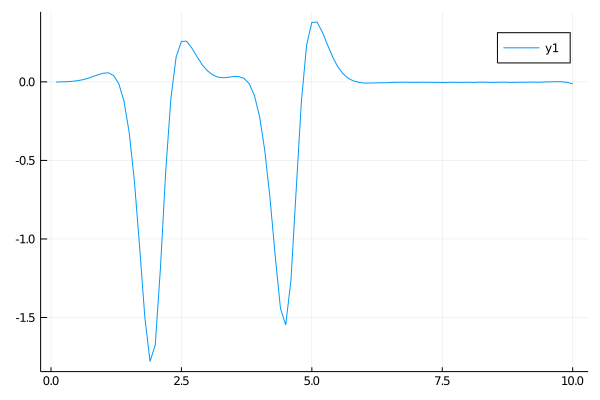

In [12]:
plot(R, S[70,:]) # see behavior of particule

In [13]:

run(`ffmpeg -framerate 1 -f image2 -i soliton_xfix%d.png gifka2.gif`)

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/miniconda3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'soliton_xfix%d.png':
  Duration: 00:01:40.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgb24(pc), 600x400,

ProcessFailedException: failed process: Process(`ffmpeg -framerate 1 -f image2 -i soliton_xfix%d.png gifka2.gif`, ProcessExited(1)) [1]
